# Week 4 - Frequentist vs Bayesian

Hello again. Welcome to week 4! In this notebook, we will focus on the differences between frequestist and Bayesian approaches.

The usual imports, plus one new package called "pystan_utils" that we developed to make your lifes easier. You will see later :-)

In [2]:
# First, we need to download an auxiliary Python file for STAN
!wget http://mlsm.man.dtu.dk/mbml/pystan_utils.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pystan_utils

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

ModuleNotFoundError: No module named 'pystan_utils'

In [0]:
# usually have to run this twice to take effect
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## Introduction

Suppose that you got a dataset $\mathcal{D} = \{x_n,y_n\}_{n=1}^N$, where for each input point $x_n$ we have a corresponding target $y_n$. Based on this data, you developed some model of the form:
\begin{align}
y_n = \alpha + \beta x_n + \epsilon_n,
\end{align}
where $\epsilon_n \sim Dist(\theta)$. 

For the purpose of this exercise, we make no assumptions on the distribution of $\epsilon$

You perfomed approximate Bayesian inference (e.g. using STAN), and you obtained a large set of samples from the posterior distributions $p(\alpha|\mathcal{D})$ and $p(\beta|\mathcal{D})$. Lets load these samples from a file:

In [0]:
samples_alpha = np.loadtxt("http://mlsm.man.dtu.dk/mbml/posterior_samples_alpha.txt")
samples_beta = np.loadtxt("http://mlsm.man.dtu.dk/mbml/posterior_samples_beta.txt")

Now, lets plot their distributions, as well as their mean, median and mode.

Note that, we will make use of two extremely useful functions from pystan_utils: "plot_kde" and "posterior_mode". The former uses Kernel Density Estimation to make smooth approximation of the distribution based on the samples, while the latter uses that same smooth approximation to compute the maximum (mode) of the distribution.

Mean alpha: 0.6533528646863405
Median alpha: 0.7153196472211516
Mode alpha: 0.8019689803261181


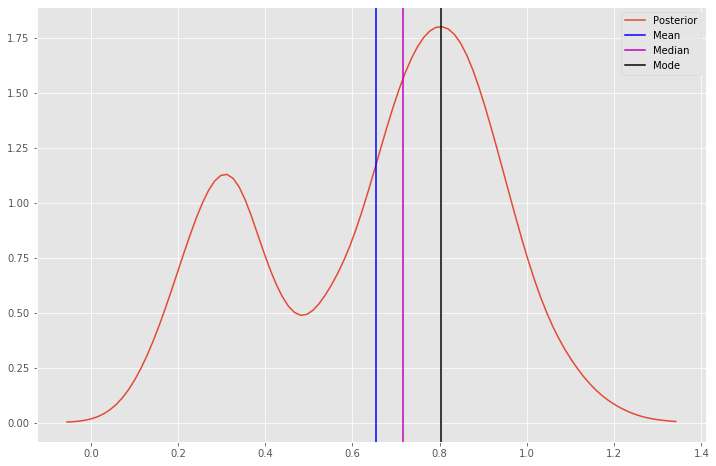

In [7]:
samples_alpha = np.array(samples_alpha)[:,np.newaxis]
pystan_utils.plot_kde(samples_alpha)
alpha_mean = np.mean(samples_alpha)
print("Mean alpha:", alpha_mean)
alpha_median = np.median(samples_alpha)
print("Median alpha:", alpha_median)
alpha_mode = pystan_utils.posterior_mode(samples_alpha[:,0])
print("Mode alpha:", alpha_mode)
plt.axvline(x=alpha_mean, c='b')
plt.axvline(x=alpha_median, c='m')
plt.axvline(x=alpha_mode, c='k')
plt.legend(["Posterior","Mean", "Median", "Mode"])
plt.show()

We can observe that the posterior distribution $p(\alpha|\mathcal{D})$ is actually bi-modal! This raises the question: if you were to take a point estimate, which would you take? Mean? Median? Mode? Because the posterior distribution is bimodal, the mean actually falls on a region of low probability. As for the mode, it completly ignores the second peak in the posterior around 0.3. The median is somewhere in between...

Well, the correct answer is none! :-) The samples from the posterior distribution are providing us such a rich description of the fully distribution, so why should we throw that information away and stick with point estimates?

But this is precisely what non fully Bayesian approches do! For example, maximum-a-posteriori (MAP) estimation tries to find the mode (point with highest probability) of the posterior. Maximum likelihood estimation (MLE) does something similar, but assumes a uniform (flat) prior over $\alpha$. In either case, using a frequentist approach, we are stuck with a point estimate of the parameters. While this is often fine for many problems, in others, a Bayesian approach can make a huge difference. 

Lets now look at the posterior distribution over $\beta$:

Mean beta: -0.5427487516294222
Median beta: -0.511699469384024
Mode beta: -0.4884810364633081


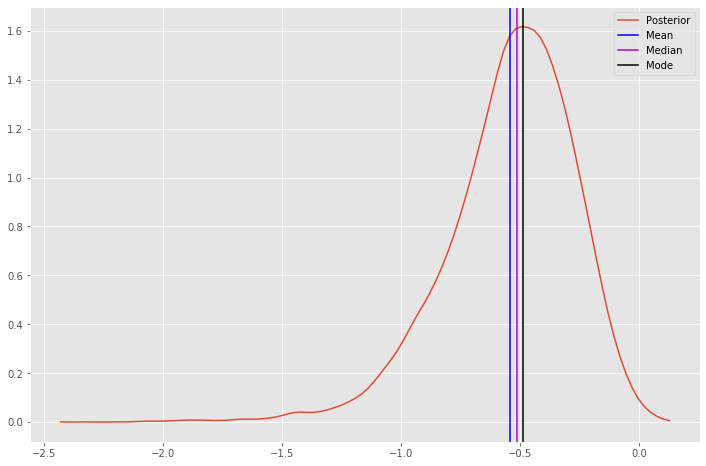

In [8]:
samples_beta = np.array(samples_beta)[:,np.newaxis]
pystan_utils.plot_kde(samples_beta)
beta_mean = np.mean(samples_beta)
print("Mean beta:", beta_mean)
beta_median = np.median(samples_beta)
print("Median beta:", beta_median)
beta_mode = pystan_utils.posterior_mode(samples_beta[:,0])
print("Mode beta:", beta_mode)
plt.axvline(x=beta_mean, c='b')
plt.axvline(x=beta_median, c='m')
plt.axvline(x=beta_mode, c='k')
plt.legend(["Posterior","Mean", "Median", "Mode"])
plt.show()

Ok, this one looks a bit more Gaussian-like. At least it is unimodal. But notice the fat tail on the left. This fat tail moves the mean of the distribution towards the left of the mode, thus making the distribution skewed. This is not characteristic of a Gaussian distribution. Maybe a log-Normal...

Notice that, since we have the full posterior, the Bayesian approach also provides us with information about the uncertainty about the estimated parameters $\alpha$ and $\beta$. But if you used MLE or MAP, you would only be able to find a point estimate of $\alpha$ and $\beta$. All these details would be lost. 

Well, how revelant can they be anyway? Lets find out...

## Analysis of the predictive posteriors at different points in the input space $x$ 

Assume that we want to predict the value of $y_*$ for a new input point $x_* = 1.0$. If we only had point estimates of $\alpha$ and $\beta$ (lets call them $\hat\alpha$ and $\hat\beta$), we could use them to predict the values of $y_*$, simply by plugging their value into the model:

\begin{align}
\hat{y}_* = \hat\alpha + \hat\beta x_*
\end{align}

Lets compare the difference between the predictions that we get if we used the mean, median and mode as point estimates. 

Can you do it?

In [9]:
x_star = 1.0

print("Prediction using (mean) point estimates:", alpha_mean + beta_mean * x_star)
print("Prediction using (median) point estimates:", alpha_median + beta_median * x_star)
print("Prediction using (mode) point estimates:", alpha_mode + beta_mode * x_star)

Prediction using (mean) point estimates: 0.11060411305691831
Prediction using (median) point estimates: 0.2036201778371276
Prediction using (mode) point estimates: 0.31348794386281


Quite different awswers, right? Which one if the correct one? Well, it depends...

Lets now explore the full posterior distributions (through the samples that we have from them), to compute the full predictive distribution. We can use the samples to approximate the predictive distribution by passing each sample $\alpha^{(s)}$ and $\beta^{(s)}$ through the model:

\begin{align}
y_*^{(s)} = \alpha^{(s)} + \beta^{(s)} x_*
\end{align}

Using the collection of samples $\{y_*^{(s)}\}$, we can obtain an approximation to the predictive posterior. 

Can you compute those samples $y_*^{(s)}$?

In [0]:
predictive_posterior = samples_alpha + samples_beta * x_star

Now lets visualize the predictive posterior and also plot the point predictions that you obtained before using the mean, median and mode of the posterior (don't forget that the mode corresponds to what you would have obtained if you used for example MAP estimation):

True mean of predictive posterior: 0.11060411305691835
True median of predictive posterior: 0.14268733985659537
True mode of predictive posterior: 0.2168110935383516


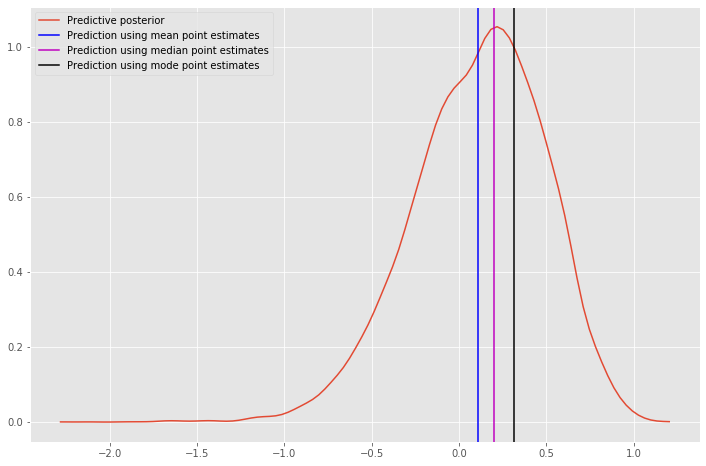

In [11]:
pystan_utils.plot_kde(predictive_posterior)
print("True mean of predictive posterior:", np.mean(predictive_posterior))
print("True median of predictive posterior:", np.median(predictive_posterior))
print("True mode of predictive posterior:", pystan_utils.posterior_mode(predictive_posterior[:,0]))

# plot predictions using point estimates (mean, median, mode) for comparison with true predictive posterior
plt.axvline(x=alpha_mean + beta_mean * x_star, c='b')
plt.axvline(x=alpha_median + beta_median * x_star, c='m')
plt.axvline(x=alpha_mode + beta_mode * x_star, c='k')
plt.legend(["Predictive posterior",
            "Prediction using mean point estimates", 
            "Prediction using median point estimates", 
            "Prediction using mode point estimates"])
plt.show()

Compare the values that you obtained with the ones from before using the point estimates. Quite different, right?

Lets now do the exact same exercise for $x_* = 0.5$:

In [12]:
x_star = 0.5

print("Prediction using (mean) point estimates:", alpha_mean + beta_mean * x_star)
print("Prediction using (median) point estimates:", alpha_median + beta_median * x_star)
print("Prediction using (mode) point estimates:", alpha_mode + beta_mode * x_star)

Prediction using (mean) point estimates: 0.3819784888716294
Prediction using (median) point estimates: 0.4594699125291396
Prediction using (mode) point estimates: 0.557728462094464


True mean of predictive posterior: 0.38197848887162944
True median of predictive posterior: 0.4263492033274562
True mode of predictive posterior: 0.5139287518412152


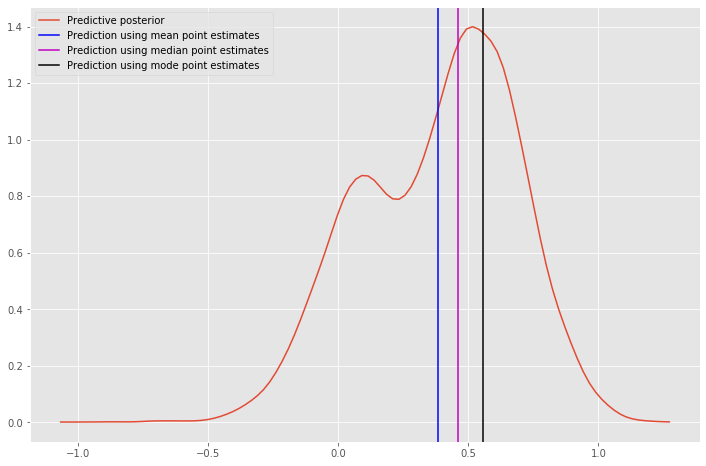

In [13]:
predictive_posterior = samples_alpha + samples_beta * x_star
pystan_utils.plot_kde(predictive_posterior)
print("True mean of predictive posterior:", np.mean(predictive_posterior))
print("True median of predictive posterior:", np.median(predictive_posterior))
print("True mode of predictive posterior:", pystan_utils.posterior_mode(predictive_posterior[:,0]))

# plot predictions using point estimates (mean, median, mode) for comparison with true predictive posterior
plt.axvline(x=alpha_mean + beta_mean * x_star, c='b')
plt.axvline(x=alpha_median + beta_median * x_star, c='m')
plt.axvline(x=alpha_mode + beta_mode * x_star, c='k')
plt.legend(["Predictive posterior",
            "Prediction using mean point estimates", 
            "Prediction using median point estimates", 
            "Prediction using mode point estimates"])
plt.show()

Different results again, right? Plus, the point prediction is not capturing that second mode of the predictive distrution.

Lets now do the exact same exercise one more time, but for $x_* = 0.1$:

In [15]:
x_star = 0.1
print("Prediction using (mean) point estimates:", alpha_mean + beta_mean * x_star)
print("Prediction using (median) point estimates:", alpha_median + beta_median * x_star)
print("Prediction using (mode) point estimates:", alpha_mode + beta_mode * x_star)

Prediction using (mean) point estimates: 0.5990779895233982
Prediction using (median) point estimates: 0.6641497002827492
Prediction using (mode) point estimates: 0.7531208766797872


True mean of predictive posterior: 0.5990779895233983
True median of predictive posterior: 0.6607162233713425
True mode of predictive posterior: 0.7502930557990055


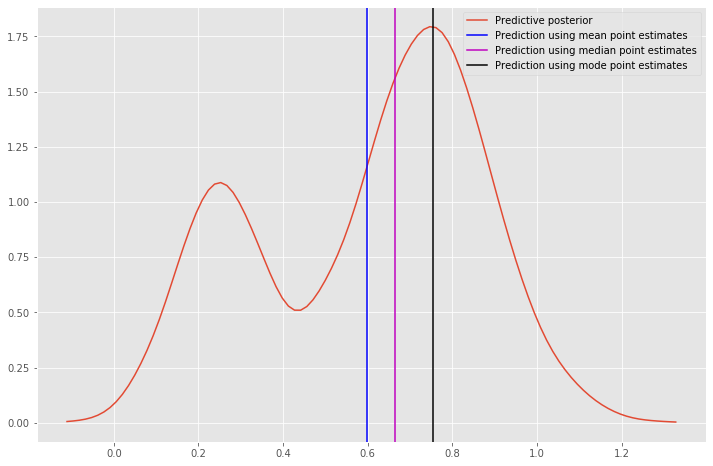

In [16]:
predictive_posterior = samples_alpha + samples_beta * x_star
pystan_utils.plot_kde(predictive_posterior)
print("True mean of predictive posterior:", np.mean(predictive_posterior))
print("True median of predictive posterior:", np.median(predictive_posterior))
print("True mode of predictive posterior:", pystan_utils.posterior_mode(predictive_posterior[:,0]))

# plot predictions using point estimates (mean, median, mode) for comparison with true predictive posterior
plt.axvline(x=alpha_mean + beta_mean * x_star, c='b')
plt.axvline(x=alpha_median + beta_median * x_star, c='m')
plt.axvline(x=alpha_mode + beta_mode * x_star, c='k')
plt.legend(["Predictive posterior",
            "Prediction using mean point estimates", 
            "Prediction using median point estimates", 
            "Prediction using mode point estimates"])
plt.show()

In this case, the true mode of the predictive distribution is actually quite close to the point estimate of $y_*$ that we obtained using the point estimate for the mode of the posterior.

However, that bi-modality issue is now even worse! And if you just computed a point estimate of $y_*$ rather than the full predictive distribution, you would have no clue about its existence! :-( Can you think of real world problems where this could be an important issue? Imagine we were trying to predict the travel time to the airport (and there are two different peaks in the distribution)... Or, imagine we were predicting the life expectancy of a patient given a treatment...

Lastly, we will do the same analysis but for the entire range $x_* \in [-0.5, 2]$ and make a visualization of the predictive distribution vs point estimates using the different alternatives (mean, median and mode).

In [0]:
from scipy.stats import kde

# compute predictive posterior for entire range
x = np.linspace(-0.5, 2, 100)[:,np.newaxis]
posterior_predictions = samples_alpha + np.dot(samples_beta, x.T)

bins = np.linspace(-1.5,1.5,100)
img = np.zeros((len(x), len(bins)))
for i in range(len(x)):
    density = kde.gaussian_kde(posterior_predictions[:,i])
    img[i,:] = density.pdf(bins)

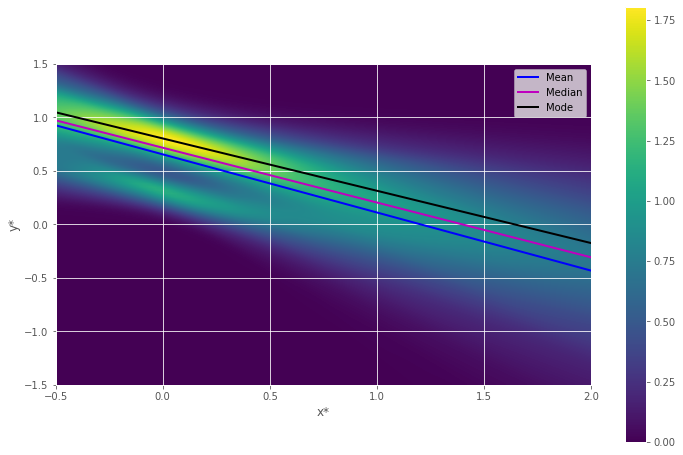

In [18]:
plt.imshow(img.T, interpolation='bilinear', origin='low', 
           extent=[np.min(x), np.max(x), np.min(bins), np.max(bins)], aspect=0.5)
plt.plot(x, alpha_mean + beta_mean * x, lw=2, c='b')
plt.plot(x, alpha_median + beta_median * x, lw=2, c='m')
plt.plot(x, alpha_mode + beta_mode * x, lw=2, c='k')
plt.xlabel("x*")
plt.ylabel("y*")
plt.legend(["Mean", "Median", "Mode"])
plt.colorbar()
plt.show()

The figure above shows the predictive density $p(y_*|x_*,\mathcal{D})$, with predictive lines that we would obtaine if we used point estimates based on the (mean, median and mode). Let us focus on that black line (mode), because that is what a MAP estimation would provide us. 

If we compare that black line with the predictive density underneath, it becomes very clear that the MAP point predictions (black line) are missing a lot of important information of the true predictive distribution, such as the  bi-modal nature of the distribution for values of $x_*$ around 0, and the fact that uncertainty increases as the value of $x_*$ increases. 

Moreover, as we saw before, for some values of $x_*$, the point predictions using MAP can be rather far from the mode of the true predictive distribution. 

Can you compute mean absolute error between those values for the range $x_* \in [-0.5, 2]$? Hint: use the for loop above as a starting point, and take advantage of the function "posterior_mode" from "pystan_utils". Also, store the absolute errors for all values of $x_* \in [-0.5, 2]$ in an array called "errors" for visualizing them afterwards.

In [19]:
errors = []
for i in range(len(x)):
    map_pred = alpha_mode + beta_mode * x[i]
    true_mode = pystan_utils.posterior_mode(posterior_predictions[:,i])
    errors += [np.abs(map_pred - true_mode)]

print("Mean absolute error (MAE):", np.mean(errors))

Mean absolute error (MAE): 0.0637502865679037


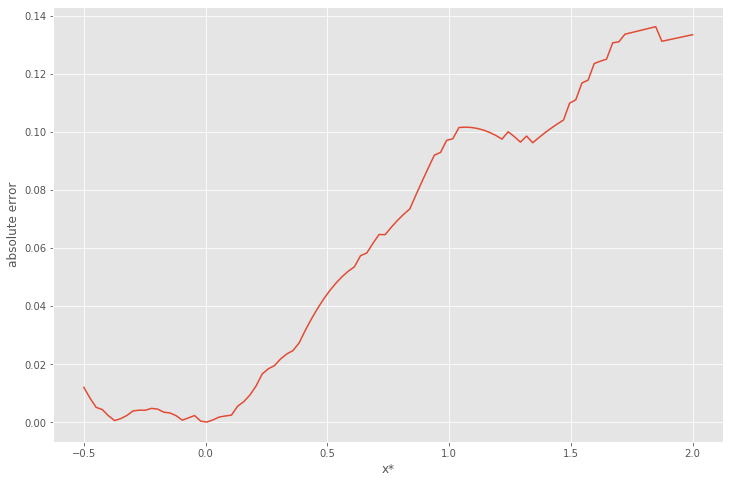

In [20]:
# plot of how error vary over x
plt.plot(x, errors)
plt.xlabel("x*")
plt.ylabel("absolute error")
plt.show()

Interesting, right? Makes you wonder what would happen if keep going beyond 2? :-)